In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

RNN gates = sliding windows over candidates.

For LSTM style unbounded gates:
$$
    h_t = p_th_{t-1} + z_t
$$
Suppose $p_i = 0.99$ for $i \in \{1, \dots, 1000\}$, what does the weighting look like at time 1001?

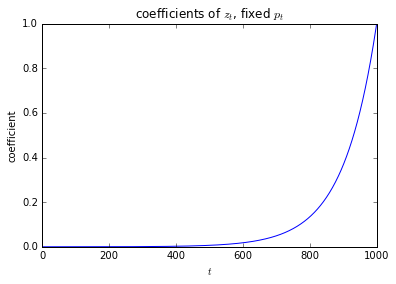

In [5]:
times = np.arange(1000)
window = np.power(0.99, times)[::-1]
plt.plot(window)
plt.title(r'coefficients of $z_t$, fixed $p_t$')
plt.xlabel(r'$t$')
plt.ylabel('coefficient')

What if we want to remember one thing specifically? Clearly if we spike once it will just get smoothed out, so the best we can do is keep the gate high and have the candidate depend somehow on the state as well?

249


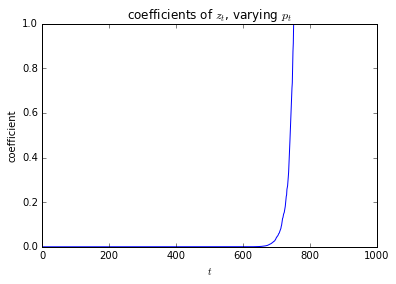

In [6]:
gates = np.random.uniform(0.9, 0.98, size=(1000,))
i = np.random.randint(gates.shape[0])
print(i)
gates[:i] = 0.99999
window = np.cumprod(gates)[::-1]
plt.plot(window)
plt.title(r'coefficients of $z_t$, varying $p_t$')
plt.xlabel(r'$t$')
plt.ylabel('coefficient')

GRUs (and our new friend) have gates that look like:
$$
    h_t = p_th_{t-1} + (1-p_t)z_t
$$ (although in some GRU papers it's the other way around). This is a little bit more tricky to calculate the sliding window, but that's why we're here.

Let's write out a few in full to see if we can find a general form.
$$
\begin{align}
    h_0 &= z_0 \\
    h_1 &= p_1z_0 + (1-p_1)z_1 \\
    h_2 &= p_2p_1z_0 + p_2(1-p_1)z_1 + (1-p_2)z_2 \\
    h_3 &= p_3p_2p_1z_0 + p_3p_2(1-p_1)z_1 + p_3(1-p_2)z_2 + (1-p_3)z_3 \\
    h_4 &= p_4p_3p_2p_1z_0 + p_4p_3p_2(1-p_1)z_1 + p_4p_3(1-p_2)z_2 + p_4(1-p_3)z_3 + (1-p_4)z_4
\end{align}
$$

Looks like it's going to be as above, but also multiplied by $(1-p_t)$: (define $p_0=0$)

$$
    h_t = \sum_{i=0}^t \left(\prod_{j=i+1}^t p_j\right) (1 - p_i) z_i
$$

Now it feels as though these coefficients should sum to one, so let's consider
$$
    \sum_{i=0}^t (1-p_i) \prod_{j=i+1}^tp_j
$$


In the case where $t=3$:
$$
\begin{align}
    p_3p_2p_1 + p_2p_3(1-p_1) + p_3(1-p_2) + (1-p_3) &= p_3p_2p_1 + p_2p_3 - p_2p_3p_1 + p_3 - p_3p_2 + 1 - p_3 \\
    &= 1
\end{align}
$$

Looks like they should all cancel out, now let's generalise and see if we can turn it into a telescoping sum.
First we have to break it up slightly, or it telescopes too far:
$$
\begin{align}
    &\sum_{i=0}^t \left(\prod_{j=i+1}^t p_j\right) (1 - p_i) \\
    &= \prod_{j=1}^tp_j(1-p_0) + (1-p_t) + \sum_{i=1}^{t-1} \left(\prod_{j=i+1}^t p_j\right) (1 - p_i) \\
    &= \prod_{j=1}^tp_j(1-p_0) + (1-p_t) + \sum_{i=1}^{t-1} \left(\prod_{j=i+1}^t p_j\right) - \left(\prod_{j=i}^t p_j\right) \\
    &= \prod_{j=1}^tp_j(1-p_0) + (1-p_t) - \prod_{k=1}^t p_k + p_t \\
    &= 1
\end{align}
$$

0.999956828753


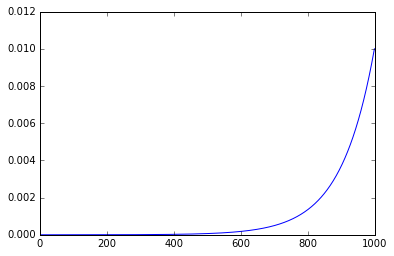

In [7]:
# first let all have the same value
window = np.power(0.99, times)[::-1]
window *= (1 - 0.99)

print(window.sum())
plt.plot(window)

It's the same, but smaller because it sums pretty much to one. But what if it jumps around a bit?

0.99998999999999938

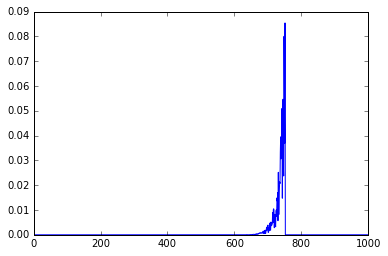

In [8]:
window = np.cumprod(gates)
window[:-1] *= 1.0 - gates[1:]
window = window[::-1]

plt.plot(window)
window.sum()
# something wrong

Can we get two spikes out of it?

1.0

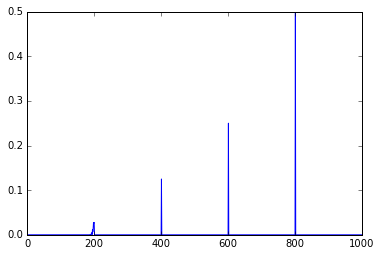

In [9]:
gates = np.random.uniform(0.5, 0.98, size=(1000,))
gates[200] = 0.5
gates[200:] = 1.0
gates[600] = 0.5
gates[400] = 0.5
gates[800] = 0.5
gates = gates[::-1]

window = np.cumprod(gates)
#plt.plot(window[::-1])
window[:-1] *= 1.0 - gates[1:]
window = window[::-1]

plt.plot(window)
window.sum()

Almost, but there is a gap in between it is not clear how to remove.